# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
import git
import sys


In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


/tmp/ipykernel_98580/2820620140.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [4]:
git_root

'/nancy/projects/nose_poke_identifier'

In [5]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [6]:
import utilities.helper
import sleap.process_pose

In [7]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1
# TONE_TIMESTAMP_DF = pd.read_csv("./proc/rce_tone_timestamp.csv", index_col=0)
# VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_excel("../../proc/video_to_frame_and_subject.xlsx")
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_pickle(os.path.join(git_root, "/nancy/projects/nose_poke_identifier/results/2023_09_07_nose_poke_extraction/proc/rce_pilot_2_00_trodes_metadata.pkl"))
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [9]:
START_STOP_FRAME_DF = pd.read_excel("./rce_per_subject_start_stop_video_frame.xlsx").dropna(subset=["file_path"])

In [10]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps
0,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
1,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [..."
3,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [..."
4,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,75876357,"[1384, 1384, 2770, 4156, 4156, 5541, 6927, 831...","[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [..."


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [11]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_2"

In [12]:
FULL_LFP_TRACES_PKL = "{}_sleap_poses.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

# Reading in the h5 files between recordings

In [13]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps
0,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
1,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,"[1.3, 1.4]",8798886,77093151,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [..."
3,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [..."
4,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,75876357,"[1384, 1384, 2770, 4156, 4156, 5541, 6927, 831...","[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [..."


- Getting the names of each subject

In [14]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].iloc[0]

'20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.2'

In [15]:
# VIDEO_TO_FRAME_AND_SUBJECT_DF["video_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: os.path.join(SLEAP_DIR, "*", x + "*.h5"))
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "*", x + "*2_subj*.h5")))
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF[VIDEO_TO_FRAME_AND_SUBJECT_DF['sleap_glob'].apply(lambda x: len(x) == 1)]
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.reset_index(drop=True)


VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_glob"].apply(lambda x: x[0])

In [16]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,last_timestamp,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,sleap_glob,sleap_path
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,76318450,"[1384, 2444, 2769, 4155, 5541, 6708, 6927, 831...","[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,75876357,"[1384, 1384, 2770, 4156, 4156, 5541, 6927, 831...","[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
3,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1, 1.4]",7454593,75876357,"[1384, 1384, 2770, 4156, 4156, 5541, 6927, 831...","[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
4,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,"[1.2, 1.4]",307664,67788422,"[1383, 1383, 2769, 4155, 5541, 5541, 6927, 831...","[[88015, 288015], [2488011, 2688012], [4788011...","[[339014, 340215], [341012, 386212], [386615, ...","[[31772990, 31773790], [31774790, 31776190], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...
5,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904

In [17]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.extract_sleap_data(x))


In [18]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [19]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [20]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0                                           [1.1, 1.2]
1                                           [1.1, 1.2]
2    [1.4, 1.1, track_901, track_902, track_903, tr...
3    [1.4, 1.1, track_901, track_902, track_903, tr...
4    [1.2, 1.4, track_685, track_686, track_687, tr...
5    [1.2, 1.4, track_685, track_686, track_687, tr...
6    [1.1, 1.4, track_867, track_868, track_869, tr...
7    [1.1, 1.4, track_867, track_868, track_869, tr...
Name: track_names, dtype: object

In [21]:
# Getting the coordinates of all the body parts for all the animals for the entire recording
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x).astype(np.float16))
# Getting the name of the tracks which correspond to the animal id
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_sleap_track_names_from_h5(x))

In [22]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"].iloc[0].shape

(68258, 6, 2, 2)

In [23]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"].iloc[0]

['1.1', '1.2']

In [24]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0                                           [1.1, 1.2]
1                                           [1.1, 1.2]
2    [1.4, 1.1, track_901, track_902, track_903, tr...
3    [1.4, 1.1, track_901, track_902, track_903, tr...
4    [1.2, 1.4, track_685, track_686, track_687, tr...
5    [1.2, 1.4, track_685, track_686, track_687, tr...
6    [1.1, 1.4, track_867, track_868, track_869, tr...
7    [1.1, 1.4, track_867, track_868, track_869, tr...
Name: track_names, dtype: object

In [25]:
# Getting the indexes of each subject from the track list
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["all_subjects"] if k in x["track_names"]}, axis=1)

In [26]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"]

0    {'1.1': 0, '1.2': 1}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 1, '1.4': 0}
3    {'1.1': 1, '1.4': 0}
4    {'1.2': 0, '1.4': 1}
5    {'1.2': 0, '1.4': 1}
6    {'1.1': 0, '1.4': 1}
7    {'1.1': 0, '1.4': 1}
Name: subject_to_index, dtype: object

In [27]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [28]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': 0, '1.2': 1}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 1, '1.4': 0}
3    {'1.1': 1, '1.4': 0}
4    {'1.2': 0, '1.4': 1}
5    {'1.2': 0, '1.4': 1}
6    {'1.1': 0, '1.4': 1}
7    {'1.1': 0, '1.4': 1}
Name: subject_to_tracks, dtype: object

In [29]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [30]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': [[[332.   127.75], [307.2 131.6], [323...
1    {'1.1': [[[332.   127.75], [307.2 131.6], [323...
2    {'1.1': [[[336.2 400.2], [319.2 388.2], [323.8...
3    {'1.1': [[[336.2 400.2], [319.2 388.2], [323.8...
4    {'1.2': [[[367.8 343.8], [399.5 336. ], [379.5...
5    {'1.2': [[[367.8 343.8], [399.5 336. ], [379.5...
6    {'1.1': [[[340.2 388.2], [324.2 380.2], [332.2...
7    {'1.1': [[[340.2 388.2], [324.2 380.2], [332.2...
Name: subject_to_tracks, dtype: object

In [31]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,sleap_glob,sleap_path,all_sleap_data,locations,track_names,subject_to_index,subject_to_tracks
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,...,"[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[[[[332. 244.4], [127.75 395.8 ]], [[307.2 24...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[332. 127.75], [307.2 131.6], [323..."
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,...,"[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[[[[332. 244.4], [127.75 395.8 ]], [[307.2 24...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[332. 127.75], [307.2 131.6], [323..."
2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,...,"[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[364.50231934 336.33197021 ...,[[[[364.5 336.2 nan nan nan nan nan ...,"[1.4, 1.1, track_901, track_902, track_903, tr...","{'1.1': 1, '1.4': 0}","{'1.1': [[[336.2 400.2], [319.2 388.2], [323.8..."
3,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1, 1.4]",7454593,...,"[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [...",[/scratch/back_up/reward_competition_extention...,/scratch/back_up/reward_competition_extention/...,{'locations': [[[[364.50231934 336.33197021 ...,[[[[364.5 336.2 nan nan nan nan nan ...,"[1.4, 1.1, track_901, track_902, track_903, tr...","{'1.1': 1, '1.4': 0}","{'1.1': [[[336.2 400.2], [319.2 388.2], [323.8..."
4,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/

## Getting the coordinates of the corners

In [32]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.2_subj.id_corrected.h5'

In [33]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].apply(lambda x: x.replace("id_corrected.h5", "corner.h5").replace(".fixed", "").replace(".round_1", "").replace(".1_subj", "").replace(".2_subj", ""))


In [34]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5'

In [35]:
# Getting the indexes of each corner location
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [36]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"]

0    [box_top_left, box_top_right, reward_port, box...
1    [box_top_left, box_top_right, reward_port, box...
2    [box_bottom_left, box_top_right, reward_port, ...
3    [box_bottom_left, box_top_right, reward_port, ...
4    [box_bottom_left, box_top_right, reward_port, ...
5    [box_bottom_left, box_top_right, reward_port, ...
6    [box_top_left, box_bottom_right, box_bottom_le...
7    [box_top_left, box_bottom_right, box_bottom_le...
Name: corner_parts, dtype: object

In [37]:
# Getting the coordinates of all the corners
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))

In [38]:
# Parsing out each corner and creating a dictionary of name to coordinates
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [39]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
1    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
2    {'box_bottom_left': [[[219.49634883], [382.936...
3    {'box_bottom_left': [[[219.49634883], [382.936...
4    {'box_bottom_left': [[[220.39193729], [383.559...
5    {'box_bottom_left': [[[220.39193729], [383.559...
6    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
7    {'box_top_left': [[[nan], [nan]], [[nan], [nan...
Name: corner_to_coordinate, dtype: object

In [40]:
# Filtering out all the Nans because there's only one labeled frame
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: v[~np.isnan(v)][:2].astype(np.float16) for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [41]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[0]

{'box_top_left': array([215.1 , 113.94], dtype=float16),
 'box_top_right': array([425.2 , 112.25], dtype=float16),
 'reward_port': array([321.8, 398.2], dtype=float16),
 'box_bottom_left': array([216.6, 380.2], dtype=float16),
 'box_bottom_right': array([425.8, 379.2], dtype=float16)}

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [42]:
# Using the x-coordinates for the width
VIDEO_TO_FRAME_AND_SUBJECT_DF["bottom_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
VIDEO_TO_FRAME_AND_SUBJECT_DF["top_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [43]:
# Using the y-coordinates for the height
VIDEO_TO_FRAME_AND_SUBJECT_DF["right_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
VIDEO_TO_FRAME_AND_SUBJECT_DF["left_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [44]:
# averaging the width and height by adding both sides and then getting the mean
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [45]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"] = MED_PC_WIDTH / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"]
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"] = MED_PC_HEIGHT / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"]

In [46]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"]

0    0.090014
1    0.090014
2    0.091168
3    0.091168
4    0.090952
5    0.090952
6    0.092486
7    0.092486
Name: height_ratio, dtype: float64

In [47]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"]

0    0.140727
1    0.140727
2    0.138946
3    0.138946
4    0.140309
5    0.140309
6    0.137609
7    0.137609
Name: width_ratio, dtype: float64

## Converting Pixels to cm

- Converting the X-dimension

In [48]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0    {'1.1': [[[332.   127.75], [307.2 131.6], [323...
1    {'1.1': [[[332.   127.75], [307.2 131.6], [323...
2    {'1.1': [[[336.2 400.2], [319.2 388.2], [323.8...
3    {'1.1': [[[336.2 400.2], [319.2 388.2], [323.8...
4    {'1.2': [[[367.8 343.8], [399.5 336. ], [379.5...
5    {'1.2': [[[367.8 343.8], [399.5 336. ], [379.5...
6    {'1.1': [[[340.2 388.2], [324.2 380.2], [332.2...
7    {'1.1': [[[340.2 388.2], [324.2 380.2], [332.2...
Name: subject_to_tracks, dtype: object

In [49]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,corner_parts,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,...,"[box_top_left, box_top_right, reward_port, box...","{'box_top_left': [215.1, 113.94], 'box_top_rig...",209.125,210.125,267.00,266.25,266.625,209.6250,0.140727,0.090014
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,...,"[box_top_left, box_top_right, reward_port, box...","{'box_top_left': [215.1, 113.94], 'box_top_rig...",209.125,210.125,267.00,266.25,266.625,209.6250,0.140727,0.090014
2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,...,"[box_bottom_left, box_top_right, reward_port, ...","{'box_bottom_left': [219.5, 383.0], 'box_top_r...",213.250,211.375,263.50,263.00,263.250,212.3125,0.138946,0.091168
3,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1, 1.4]",7454593,...,"[box_bottom_left, box_top_right, reward_port, ...","{'box_bottom_left': [219.5, 383.0], 'box_top_r...",213.250,211.375,263.50,263.00,263.250,212.3125,0.138946,0.091168
4,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,"[1.2, 1.4]",307664,...,"[box_bottom_left, box_top_right, reward_port, ...","{'box_bottom_left': [220.4, 383.5], 'box_top_r...",210.125,210.375,266.75,261.00,263.875,210.2500,0.140309,0.090952
5,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,"[1.2, 1.4]",307664,...,"[box_bottom_left, box_top_right, reward_port, ...","{'box_bottom_left': [220.4, 383.5], 'box_top_r...",210.125,210.375,266.75,261.00,263.875,210.2500,0.140309,0.090952
6,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...","[[33026, 33037], [33038, 33042], [33044, 33049...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1.4]"

In [50]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: sleap.process_pose.fill_missing(sleap.process_pose.rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"])) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [51]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: sleap.process_pose.rescale_dimension_in_array(value, dimension=1, ratio=x["height_ratio"]) for key, value in x["rescaled_locations"].items()}, axis=1)

In [52]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [215.1, 113.94], 'box_top_rig...
1    {'box_top_left': [215.1, 113.94], 'box_top_rig...
2    {'box_bottom_left': [219.5, 383.0], 'box_top_r...
3    {'box_bottom_left': [219.5, 383.0], 'box_top_r...
4    {'box_bottom_left': [220.4, 383.5], 'box_top_r...
5    {'box_bottom_left': [220.4, 383.5], 'box_top_r...
6    {'box_top_left': [210.2, 125.06], 'box_bottom_...
7    {'box_top_left': [210.2, 125.06], 'box_bottom_...
Name: corner_to_coordinate, dtype: object

In [53]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio,rescaled_locations
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,...,"{'box_top_left': [215.1, 113.94], 'box_top_rig...",209.125,210.125,267.00,266.25,266.625,209.6250,0.140727,0.090014,"{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56..."
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,...,"{'box_top_left': [215.1, 113.94], 'box_top_rig...",209.125,210.125,267.00,266.25,266.625,209.6250,0.140727,0.090014,"{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56..."
2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,...,"{'box_bottom_left': [219.5, 383.0], 'box_top_r...",213.250,211.375,263.50,263.00,263.250,212.3125,0.138946,0.091168,"{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97..."
3,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1, 1.4]",7454593,...,"{'box_bottom_left': [219.5, 383.0], 'box_top_r...",213.250,211.375,263.50,263.00,263.250,212.3125,0.138946,0.091168,"{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97..."
4,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,"[1.2, 1.4]",307664,...,"{'box_bottom_left': [220.4, 383.5], 'box_top_r...",210.125,210.375,266.75,261.00,263.875,210.2500,0.140309,0.090952,"{'1.2': [[[51.6 31.27], [56.03 30.56], [53.22..."
5,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.4,"[1.2, 1.4]",307664,...,"{'box_bottom_left': [220.4, 383.5], 'box_top_r...",210.125,210.375,266.75,261.00,263.875,210.2500,0.140309,0.090952,"{'1.2': [[[51.6 31.27], [56.03 30.56], [53.22..."
6,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...","[[33026, 33037], [33038, 33042], [33044, 33049...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,"[1.1, 1

In [54]:
# Normalize dictionary column
normalized = pd.json_normalize(VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"])

In [55]:
normalized

,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,"[215.1, 113.94]","[425.2, 112.25]","[321.8, 398.2]","[216.6, 380.2]","[425.8, 379.2]"
1,"[215.1, 113.94]","[425.2, 112.25]","[321.8, 398.2]","[216.6, 380.2]","[425.8, 379.2]"
2,"[211.9, 120.0]","[423.2, 112.3]","[326.2, 399.0]","[219.5, 383.0]","[432.8, 375.8]"
3,"[211.9, 120.0]","[423.2, 112.3]","[326.2, 399.0]","[219.5, 383.0]","[432.8, 375.8]"
4,"[212.9, 122.4]","[423.2, 116.7]","[325.8, 402.8]","[220.4, 383.5]","[430.5, 383.5]"
5,"[212.9, 122.4]","[423.2, 116.7]","[325.8, 402.8]","[220.4, 383.5]","[430.5, 383.5]"
6,"[210.2, 125.06]","[423.2, 119.94]","[324.0, 403.5]","[216.5, 381.5]","[432.2, 382.5]"
7,"[210.2, 125.06]","[423.2, 119.94]","[324.0, 403.5]","[216.5, 381.5]","[432.2, 382.5]"


In [56]:


# Drop the original column and concat the normalized DataFrame
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.concat([VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [57]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,...,266.625,209.6250,0.140727,0.090014,"{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[215.1, 113.94]","[425.2, 112.25]","[321.8, 398.2]","[216.6, 380.2]","[425.8, 379.2]"
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,...,266.625,209.6250,0.140727,0.090014,"{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[215.1, 113.94]","[425.2, 112.25]","[321.8, 398.2]","[216.6, 380.2]","[425.8, 379.2]"
2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,...,263.250,212.3125,0.138946,0.091168,"{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...","[211.9, 120.0]","[423.2, 112.3]","[326.2, 399.0]","[219.5, 383.0]","[432.8, 375.8]"
3,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1, 1.4]",7454593,...,263.250,212.3125,0.138946,0.091168,"{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...","[211.9, 120.0]","[423.2, 112.3]","[326.2, 399.0]","[219.5, 383.0]","[432.8, 375.8]"
4,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,"[1.2, 1.4]",307664,...,263.875,210.2500,0.140309,0.090952,"{'1.2': [[[51.6 31.27], [56.03 30.56], [53.22...","[212.9, 122.4]","[423.2, 116.7]","[325.8, 402.8]","[220.4, 383.5]","[430.5, 383.5]"


In [58]:
for corner in VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"].iloc[0]:
    VIDEO_TO_FRAME_AND_SUBJECT_DF[corner] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

In [59]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,...,266.625,209.6250,0.140727,0.090014,"{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]"
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,...,266.625,209.6250,0.140727,0.090014,"{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]"
2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,...,263.250,212.3125,0.138946,0.091168,"{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...","[29.43921106858993, 10.94017094017094]","[58.80894907271121, 10.23931623931624]","[45.33117456579334, 36.376068376068375]","[30.498675301736824, 34.91737891737892]","[60.128937297615536, 34.256410256410255]"
3,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1, 1.4]",7454593,...,263.250,212.3125,0.138946,0.091168,"{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...","[29.43921106858993, 10.94017094017094]","[58.80894907271121, 10.23931623931624]","[45.33117456579334, 36.376068376068375]","[30.498675301736824, 34.91737891737892]","[60.128937297615536, 34.256410256410255]"
4,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,"[1.2, 1.4]",307664,...,263.875,210.2500,0.140309,0.090952,"{'1.2': [[[51.6 31.27], [56.03 30.56], [53.22...","[29.868311533888228, 11.130270014211275]","[59.38585017835909, 10.612979630506869]","[45.705707491082045, 36.63098057792516]","[30.92063020214031, 34.88015158692563]","[60.40309155766944, 34.88015158692563]"
5,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_co

## Looking over the tracks

In [60]:
FILE_INDEX = 0

In [61]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[FILE_INDEX]

'/scratch/back_up/reward_competition_extention/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.2_subj.id_corrected.h5'

In [62]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"]

0    {'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...
1    {'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...
2    {'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...
3    {'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...
4    {'1.2': [[[51.6  31.27], [56.03 30.56], [53.22...
5    {'1.2': [[[51.6  31.27], [56.03 30.56], [53.22...
6    {'1.1': [[[46.8 35.9], [44.6  35.16], [45.72 3...
7    {'1.1': [[[46.8 35.9], [44.6  35.16], [45.72 3...
Name: rescaled_locations, dtype: object

In [63]:
with h5py.File(VIDEO_TO_FRAME_AND_SUBJECT_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = VIDEO_TO_FRAME_AND_SUBJECT_DF["current_subject"].iloc[FILE_INDEX]
    locations = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(68258, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [64]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

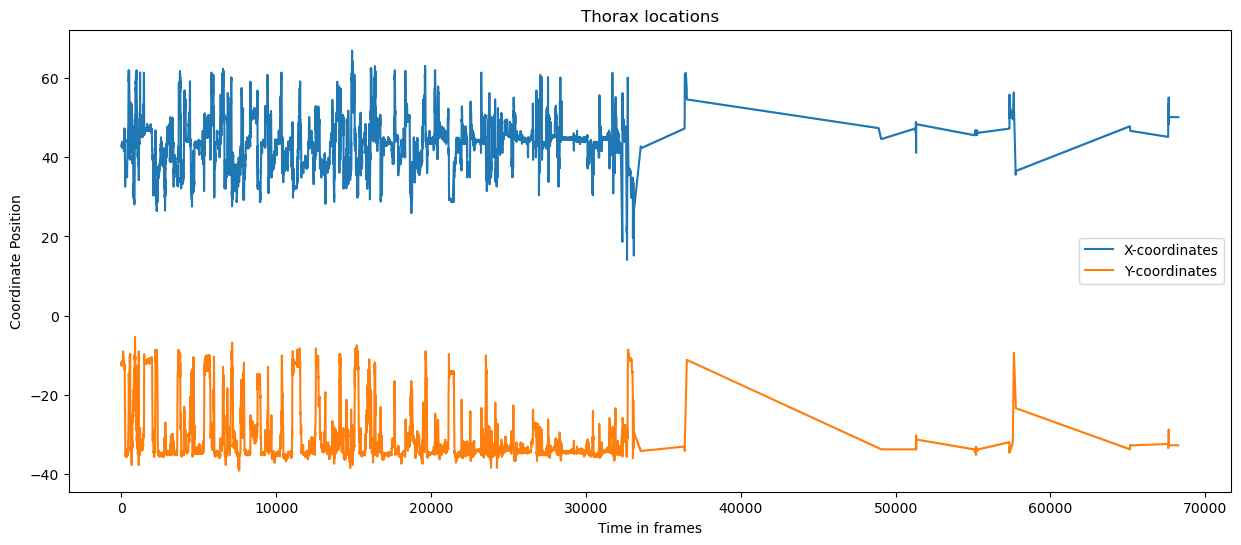

In [65]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

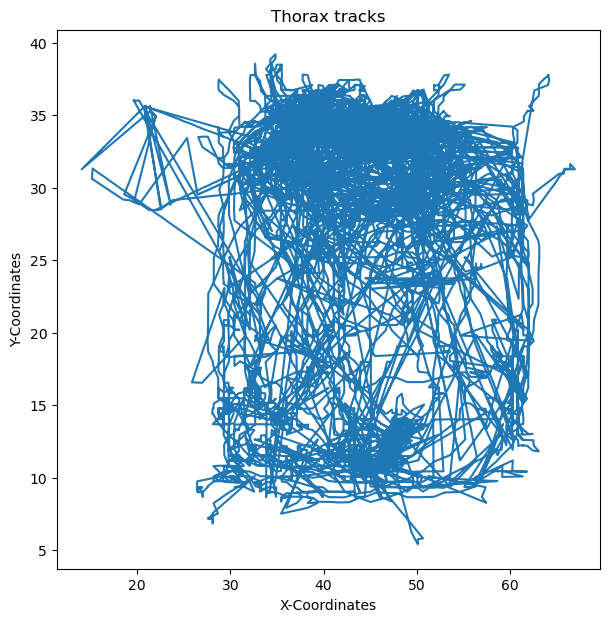

In [66]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


In [67]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,all_subjects,first_timestamp,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[1.1, 1.2]",7977066,...,266.625,209.6250,0.140727,0.090014,"{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]"
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[1.1, 1.2]",7977066,...,266.625,209.6250,0.140727,0.090014,"{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]"
2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[1.1, 1.4]",7454593,...,263.250,212.3125,0.138946,0.091168,"{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...","[29.43921106858993, 10.94017094017094]","[58.80894907271121, 10.23931623931624]","[45.33117456579334, 36.376068376068375]","[30.498675301736824, 34.91737891737892]","[60.128937297615536, 34.256410256410255]"
3,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,"[1.1, 1.4]",7454593,...,263.250,212.3125,0.138946,0.091168,"{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...","[29.43921106858993, 10.94017094017094]","[58.80894907271121, 10.23931623931624]","[45.33117456579334, 36.376068376068375]","[30.498675301736824, 34.91737891737892]","[60.128937297615536, 34.256410256410255]"
4,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,20230616_111904_standard_comp_to_training_D4_s...,1.2,"[1.2, 1.4]",307664,...,263.875,210.2500,0.140309,0.090952,"{'1.2': [[[51.6 31.27], [56.03 30.56], [53.22...","[29.868311533888228, 11.130270014211275]","[59.38585017835909, 10.612979630506869]","[45.705707491082045, 36.63098057792516]","[30.92063020214031, 34.88015158692563]","[60.40309155766944, 34.88015158692563]"
5,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...","[[31729, 31729], [31731, 31732], [31733, 31735...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_co

## Getting the location of the nose

In [68]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].iloc[0]["node_names"]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [69]:
# Getting the index of the nose
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["node_names"].index("nose"))
# Dropping to save memory
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["all_sleap_data"], errors="ignore")

## Creating a row for each port entry

- Removing duplicate rows from the same video

In [70]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop_duplicates(subset=["video_name"])

- Removing unnecessary columns

In [71]:
COLS_TO_DROP = ["sleap_glob", "sleap_path", "corner_path", "corner_parts", "corner_to_coordinate", "bottom_width", "top_width", "right_height", "left_height", "average_height", "average_width", "width_ratio", "height_ratio", "current_subject", "recording", "subject_to_tracks", "subject_to_index", "box_2_port_entry_timestamps", "locations", "box_2_port_entry_frames", "track_names", "video_timestamps"]

VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=COLS_TO_DROP, errors="ignore")

In [72]:
VIDEO_TO_FRAME_AND_SUBJECT_DF

,session_dir,tone_frames,box_1_port_entry_frames,video_name,session_path,all_subjects,first_timestamp,last_timestamp,tone_timestamps,box_1_port_entry_timestamps,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,nose_index
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[[192745, 249350], [389747, 407142], [917544, ...","{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2
2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.4]",7454593,75876357,"[[918755, 1118758], [3318755, 3518757], [56187...","[[49358, 67558], [70155, 79355], [360955, 3671...","{'1.1': [[[46.72 36.5 ], [44.34 35.4 ], [44.97...","[29.43921106858993, 10.94017094017094]","[58.80894907271121, 10.23931623931624]","[45.33117456579334, 36.376068376068375]","[30.498675301736824, 34.91737891737892]","[60.128937297615536, 34.256410256410255]",2
4,20230616_111904_standard_comp_to_training_D4_s...,"[[87, 287], [2483, 2683], [4778, 4979], [6575,...","[[338, 339], [341, 385], [385, 482], [696, 703...",20230616_111904_standard_comp_to_training_D4_s...,/scratch/back_up/reward_competition_extention/...,"[1.2, 1.4]",307664,67788422,"[[88015, 288015], [2488011, 2688012], [4788011...","[[339014, 340215], [341012, 386212], [386615, ...","{'1.2': [[[51.6 31.27], [56.03 30.56], [53.22...","[29.868311533888228, 11.130270014211275]","[59.38585017835909, 10.612979630506869]","[45.705707491082045, 36.63098057792516]","[30.92063020214031, 34.88015158692563]","[60.40309155766944, 34.88015158692563]",2
6,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.4]",835680,66439621,"[[1099250, 1299250], [3499256, 3699252], [5799...","[[788852, 836852], [838652, 840050], [840652, ...","{'1.1': [[[46.8 35.9], [44.6 35.16], [45.72 3...","[28.932361516034984, 11.566473988439306]","[58.243148688046645, 11.092485549132947]","[44.58542274052478, 37.31791907514451]","[29.792419825072884, 35.28323699421965]","[59.48163265306122, 35.3757225433526]",2


In [73]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.explode(['box_1_port_entry_frames', 'box_1_port_entry_timestamps']).reset_index(drop=True)



In [74]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["entry_length"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["box_1_port_entry_frames"].apply(lambda x: x[1] - x[0])
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF[VIDEO_TO_FRAME_AND_SUBJECT_DF["entry_length"] >= 1].reset_index(drop=True)

In [75]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,video_name,session_path,all_subjects,first_timestamp,last_timestamp,tone_timestamps,box_1_port_entry_timestamps,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,nose_index,entry_length
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[192, 248]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[192745, 249350]","{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,56
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[389, 405]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[389747, 407142]","{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,16
2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[916, 929]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[917544, 931741]","{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,13
3,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[929, 948]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[932141, 950539]","{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,19
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[961, 983]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[963342, 986354]","{'1.1': [[[46.72 11.5 ], [43.25 11.85], [45.56...","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,22


In [76]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["box_1_port_entry_start"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["box_1_port_entry_frames"].apply(lambda x: x[0])
VIDEO_TO_FRAME_AND_SUBJECT_DF["box_1_port_entry_end"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["box_1_port_entry_frames"].apply(lambda x: x[1])

In [77]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sliced_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: value[x["box_1_port_entry_start"]: x["box_1_port_entry_end"]].astype(np.float16) for key, value in x["rescaled_locations"].items()}, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["rescaled_locations"], errors="ignore")

In [78]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["sliced_locations"]

0       {'1.1': [[[47.88 11.6 ], [46.72  12.984], [48....
1       {'1.1': [[[46.1  33.44], [43.97 34.94], [46.16...
2       {'1.1': [[[61.34 18.  ], [58.6  18.38], [60.25...
3       {'1.1': [[[59.7   15.125], [60.84 16.25], [61....
4       {'1.1': [[[58.62 12.96], [60.28 14.03], [59.75...
                              ...                        
3486    {'1.1': [[[16.97 17.72], [18.67 17.39], [18.75...
3487    {'1.1': [[[16.97 17.72], [18.67 17.39], [18.75...
3488    {'1.1': [[[16.97 17.72], [18.67 17.39], [18.75...
3489    {'1.1': [[[16.97 17.72], [18.67 17.39], [18.75...
3490    {'1.1': [[[16.97 17.72], [18.67 17.39], [18.75...
Name: sliced_locations, Length: 3491, dtype: object

In [79]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,video_name,session_path,all_subjects,first_timestamp,last_timestamp,tone_timestamps,box_1_port_entry_timestamps,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,nose_index,entry_length,box_1_port_entry_start,box_1_port_entry_end,sliced_locations
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[192, 248]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[192745, 249350]","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,56,192,248,"{'1.1': [[[47.88 11.6 ], [46.72 12.984], [48...."
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[389, 405]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[389747, 407142]","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,16,389,405,"{'1.1': [[[46.1 33.44], [43.97 34.94], [46.16..."
2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[916, 929]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[917544, 931741]","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,13,916,929,"{'1.1': [[[61.34 18. ], [58.6 18.38], [60.25..."
3,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[929, 948]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[932141, 950539]","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,19,929,948,"{'1.1': [[[59.7 15.125], [60.84 16.25], [61...."
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[961, 983]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[963342, 986354]","[30.27400119260584, 10.255977496483826]","[59.844364937388185, 10.10407876230661]","[45.279069767441854, 35.848101265822784]","[30.48509242695289, 34.22784810126582]","[59.91472868217054, 34.137834036568215]",2,22,961,983,"{'1.1': [[[58.62 12.96], [60.28 14.03], [59.75..."


## Getting the coordinates of the nose

In [80]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_coordinates"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {key: value[:,x["nose_index"],:] for key, value in x["sliced_locations"].items()}, axis=1)
                                                                                        

# Calculating the distance from thorax to reward port

In [81]:
# Calculating the distance between the nose and the reward port for the first frame during the port entry
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_to_reward_port_distance"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: {key: np.linalg.norm(value - row["reward_port"], axis=1)[0] for key, value in row["nose_coordinates"].items()}, axis=1)
                                                                                                

In [82]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_to_reward_port_distance"].head()

0    {'1.1': 22.351771133170907, '1.2': 0.988053123...
1    {'1.1': 0.8902350171923165, '1.2': 25.90464148...
2    {'1.1': 21.949273716111037, '1.2': 1.066196743...
3    {'1.1': 25.589320821862895, '1.2': 0.630309449...
4    {'1.1': 26.99243314043086, '1.2': 0.6916250894...
Name: nose_to_reward_port_distance, dtype: object

## Seeing which mouse is closer to the port and labeling contested port entries

In [83]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["entry_winner"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: min(x["nose_to_reward_port_distance"], key=x["nose_to_reward_port_distance"].get), axis=1)

In [84]:
# Labeling trials as contested if the distance for both animals is reward port is small
# NOTE: change the threshold if needed
VIDEO_TO_FRAME_AND_SUBJECT_DF["contested"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["nose_to_reward_port_distance"].apply(lambda x: all((value) <= 1.5 for value in x.values()))

In [85]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,session_dir,tone_frames,box_1_port_entry_frames,video_name,session_path,all_subjects,first_timestamp,last_timestamp,tone_timestamps,box_1_port_entry_timestamps,...,box_bottom_right,nose_index,entry_length,box_1_port_entry_start,box_1_port_entry_end,sliced_locations,nose_coordinates,nose_to_reward_port_distance,entry_winner,contested
0,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[192, 248]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[192745, 249350]",...,"[59.91472868217054, 34.137834036568215]",2,56,192,248,"{'1.1': [[[47.88 11.6 ], [46.72 12.984], [48....","{'1.1': [[48.3, 13.7], [47.84, 13.695], [47.75...","{'1.1': 22.351771133170907, '1.2': 0.988053123...",1.2,False
1,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[389, 405]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[389747, 407142]",...,"[59.91472868217054, 34.137834036568215]",2,16,389,405,"{'1.1': [[[46.1 33.44], [43.97 34.94], [46.16...","{'1.1': [[46.16, 36.0], [46.12, 35.97], [46.16...","{'1.1': 0.8902350171923165, '1.2': 25.90464148...",1.1,False
2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[916, 929]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[917544, 931741]",...,"[59.91472868217054, 34.137834036568215]",2,13,916,929,"{'1.1': [[[61.34 18. ], [58.6 18.38], [60.25...","{'1.1': [[60.25, 19.8], [60.78, 19.5], [60.78,...","{'1.1': 21.949273716111037, '1.2': 1.066196743...",1.2,False
3,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[929, 948]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[932141, 950539]",...,"[59.91472868217054, 34.137834036568215]",2,19,929,948,"{'1.1': [[[59.7 15.125], [60.84 16.25], [61....","{'1.1': [[61.47, 16.03], [61.22, 15.4], [61.0,...","{'1.1': 25.589320821862895, '1.2': 0.630309449...",1.2,False
4,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[961, 983]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[963342, 986354]",...,"[59.91472868217054, 34.137834036568215]",2,22,961,983,"{'1.1': [[[58.62 12.96], [60.28 14.03], [59.75...","{'1.1': [[59.75, 13.06], [59.88, 14.26], [59.9...","{'1.1': 26.99243314043086, '1.2': 0.6916250894...",1.2,False


In [86]:
VIDEO_TO_FRAME_AND_SUBJECT_DF[VIDEO_TO_FRAME_AND_SUBJECT_DF["contested"]].head()

,session_dir,tone_frames,box_1_port_entry_frames,video_name,session_path,all_subjects,first_timestamp,last_timestamp,tone_timestamps,box_1_port_entry_timestamps,...,box_bottom_right,nose_index,entry_length,box_1_port_entry_start,box_1_port_entry_end,sliced_locations,nose_coordinates,nose_to_reward_port_distance,entry_winner,contested
154,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[9718, 9719]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[9735938, 9738333]",...,"[59.91472868217054, 34.137834036568215]",2,1,9718,9719,"{'1.1': [[[40.5 34.56], [39.4 35.7], [43.94 3...","{'1.1': [[43.94, 36.3]], '1.2': [[44.66, 36.16]]}","{'1.1': 1.4196744786109914, '1.2': 0.694881360...",1.2,True
155,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[9720, 9868]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[9739343, 9887730]",...,"[59.91472868217054, 34.137834036568215]",2,148,9720,9868,"{'1.1': [[[40.5 34.94], [38.9 36.3], [44.44 3...","{'1.1': [[44.44, 36.4], [44.97, 36.7], [44.78,...","{'1.1': 1.0098364634611707, '1.2': 0.588110045...",1.2,True
156,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[9870, 9899]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[9888732, 9917332]",...,"[59.91472868217054, 34.137834036568215]",2,29,9870,9899,"{'1.1': [[[42.22 34.97], [40.6 37.1], [44.84 3...","{'1.1': [[44.84, 36.72], [44.75, 36.72], [44.6...","{'1.1': 0.9734128200563306, '1.2': 0.598293383...",1.2,True
165,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[10516, 10518]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[10536335, 10539137]",...,"[59.91472868217054, 34.137834036568215]",2,2,10516,10518,"{'1.1': [[[39.97 34.56], [38.9 35.6], [44.44 3...","{'1.1': [[44.44, 36.0], [43.9, 36.0]], '1.2': ...","{'1.1': 0.855168345366441, '1.2': 0.4728801936...",1.2,True
167,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[10640, 10723]",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,"[1.1, 1.2]",7977066,76318450,"[[1126742, 1326741], [3526740, 3726740], [5826...","[10660132, 10744137]",...,"[59.91472868217054, 34.137834036568215]",2,83,10640,10723,"{'1.1': [[[42.28 34.6 ], [40.88 36.1 ], [44.8 ...","{'1.1': [[44.8, 36.44], [44.56, 36.5], [44.28,...","{'1.1': 0.7517168454547564, '1.2': 1.168323123...",1.1,True


In [87]:
VIDEO_TO_FRAME_AND_SUBJECT_DF[VIDEO_TO_FRAME_AND_SUBJECT_DF["contested"]].shape

(71, 24)

In [88]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

Index(['session_dir', 'tone_frames', 'box_1_port_entry_frames', 'video_name',
       'session_path', 'all_subjects', 'first_timestamp', 'last_timestamp',
       'tone_timestamps', 'box_1_port_entry_timestamps', 'box_top_left',
       'box_top_right', 'reward_port', 'box_bottom_left', 'box_bottom_right',
       'nose_index', 'entry_length', 'box_1_port_entry_start',
       'box_1_port_entry_end', 'sliced_locations', 'nose_coordinates',
       'nose_to_reward_port_distance', 'entry_winner', 'contested'],
      dtype='object')

In [89]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.to_pickle(os.path.join(OUTPUT_DIR, "rce_pilot_2_nose_pokes.pkl"))